In [86]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchview import draw_graph

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


# モデル定義


In [87]:
class BuckConverterRNNCell(nn.Module):
    def __init__(
        self,
        L_init: float,
        C_init: float,
        R_init: float,
    ) -> None:
        super().__init__()
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self,
        h: torch.Tensor,
        x: torch.Tensor,
        dt: torch.Tensor,
    ) -> torch.Tensor:
        """
        h: [Batch, 2] = [iL, vC]
        x: [Batch, 2] = [vs, u]
        dt: [Batch, 1]
        """

        device = h.device
        dt = dt.to(device)

        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        iL = h[:, 0]
        vC = h[:, 1]
        vs = x[:, 0]
        u = x[:, 1]

        vp = vs * u  # vs(t) * u(t)

        iL_next = iL + (dt / L) * (vp - vC)
        vC_next = vC + (dt / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1)


class BuckConverterRNNModel(nn.Module):
    def __init__(
        self,
        L_init: float,
        C_init: float,
        R_init: float,
    ) -> None:
        super().__init__()
        self.cell = BuckConverterRNNCell(L_init, C_init, R_init)

    def forward(
        self,
        h0: torch.Tensor,
        xs: torch.Tensor,
        dt: torch.Tensor,
    ) -> torch.Tensor:
        """
        h0: [Batch, 2] 初期状態
        xs: [TimeStep, Batch, 2] 各時刻の入力 [vs, u]
        dt: [TimeStep, Batch, 1] 各時刻の時間刻み
        return: [TimeStep+1, Batch, 2]  各時刻の h_t
        """
        T, B, _ = xs.shape
        h = h0
        outputs = [h0]
        for t in range(T):
            h = self.cell(h, xs[t], dt[t])  # 自己ループ
            outputs.append(h)
        return torch.stack(outputs, dim=0)


# モデルの可視化


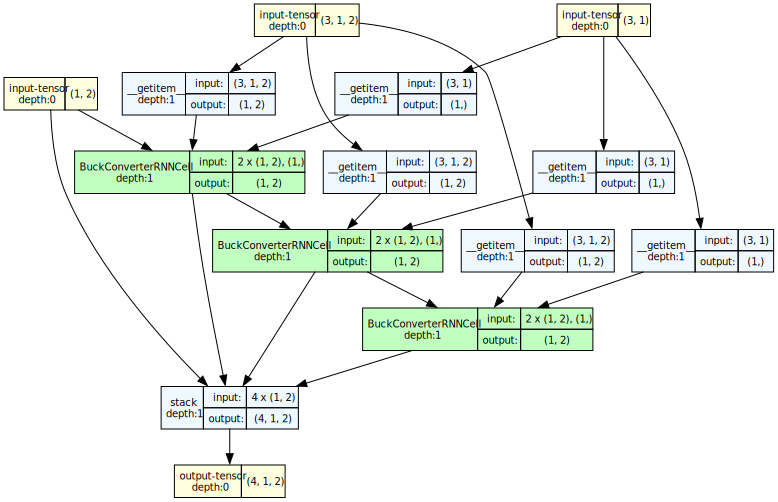

'tmp/model_graph_torchview.png'

In [88]:
model = BuckConverterRNNModel(L_init=1, C_init=1, R_init=1)


# ダミーデータを作成
dummy_batch_size = 1
dummy_time_step = 3

# [Batch, 2] = [iL, vC]
h_dummy = torch.randn(dummy_batch_size, 2)
# [TimeStep, Batch, 2] = [vs, u]
x_dummy = torch.randn(dummy_time_step, dummy_batch_size, 2)
# [TimeStep, Batch, 1]
dt_dummy = torch.randn(dummy_time_step, dummy_batch_size)

model_graph = draw_graph(
    model,
    input_data=[h_dummy, x_dummy, dt_dummy],
    expand_nested=True,
)
display(model_graph.visual_graph)

model_graph.visual_graph.render(
    filename="tmp/model_graph_torchview",
    format="png",
)

# 学習データ作成


len(t)=200001
(200001,)
len(dt)=200000
(200000,)
len(u)=200000
(200000,)
len(vs)=200000
(200000,)


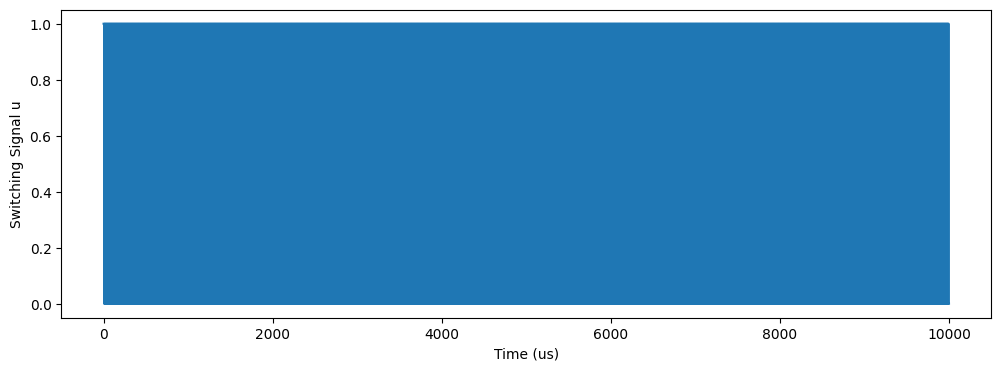

In [89]:
# 学習データを作成
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin: float = 10
Vref: float = 6
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
points_per_cycle: int = 200  # 1周期あたりのプロット数
cycles: int = 1000  # 周期数

t: np.ndarray = np.linspace(0, cycles * T, cycles * points_per_cycle + 1)
dt: np.ndarray = np.diff(t)

# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

print(f"{len(t)=}")
print(t.shape)
print(f"{len(dt)=}")
print(dt.shape)
print(f"{len(u)=}")
print(u.shape)
print(f"{len(vs)=}")
print(vs.shape)

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u")
plt.show()

In [90]:
# シミュレーション用のデータを整形
# h0: [Batch, 2] 初期状態 [iL, vC]
# xs: [TimeStep, Batch, 2] 各時刻の入力 [vs, u]
# dt: [TimeStep, Batch, 1] 各時刻の時間刻み

# numpy配列をテンソルに変換
dt_tensor = torch.tensor(dt, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
vs_tensor = torch.tensor(vs, dtype=torch.float32)

# 初期状態（iL=0, vC=0）
h0_sim = torch.zeros(1, 2, dtype=torch.float32)  # [1, 2]

# 入力データを整形
# xs: [TimeStep, Batch, 2] = [vs, u]
xs_sim = torch.stack(
    [
        vs_tensor.unsqueeze(1),  # [TimeStep, 1]
        u_tensor.unsqueeze(1),  # [TimeStep, 1]
    ],
    dim=2,
)  # [TimeStep, 1, 2]

# 時間刻みを整形
# input_dt: [TimeStep, Batch, 1]
input_dt_sim = dt_tensor.unsqueeze(1)  # [TimeStep, 1]

print(f"{h0_sim.shape=}")
print(f"{xs_sim.shape=}")
print(f"{input_dt_sim.shape=}")


h0_sim.shape=torch.Size([1, 2])
xs_sim.shape=torch.Size([200000, 1, 2])
input_dt_sim.shape=torch.Size([200000, 1])


In [91]:
# モデルを作成
model_true = BuckConverterRNNModel(
    L_init=L_true,
    C_init=C_true,
    R_init=R_true,
)

# シミュレーション
with torch.no_grad():
    h_pred_train = model_true(h0_sim, xs_sim, input_dt_sim)

# 予測結果を1次元numpy配列に変換
# h_pred_train[:, 0, 0] で [TimeStep] の形状になる
iL = h_pred_train[:, 0, 0].cpu().detach().numpy()  # [TimeStep]
vC = h_pred_train[:, 0, 1].cpu().detach().numpy()  # [TimeStep]

print(f"{iL.shape=}")
print(f"{vC.shape=}")


iL.shape=(200001,)
vC.shape=(200001,)


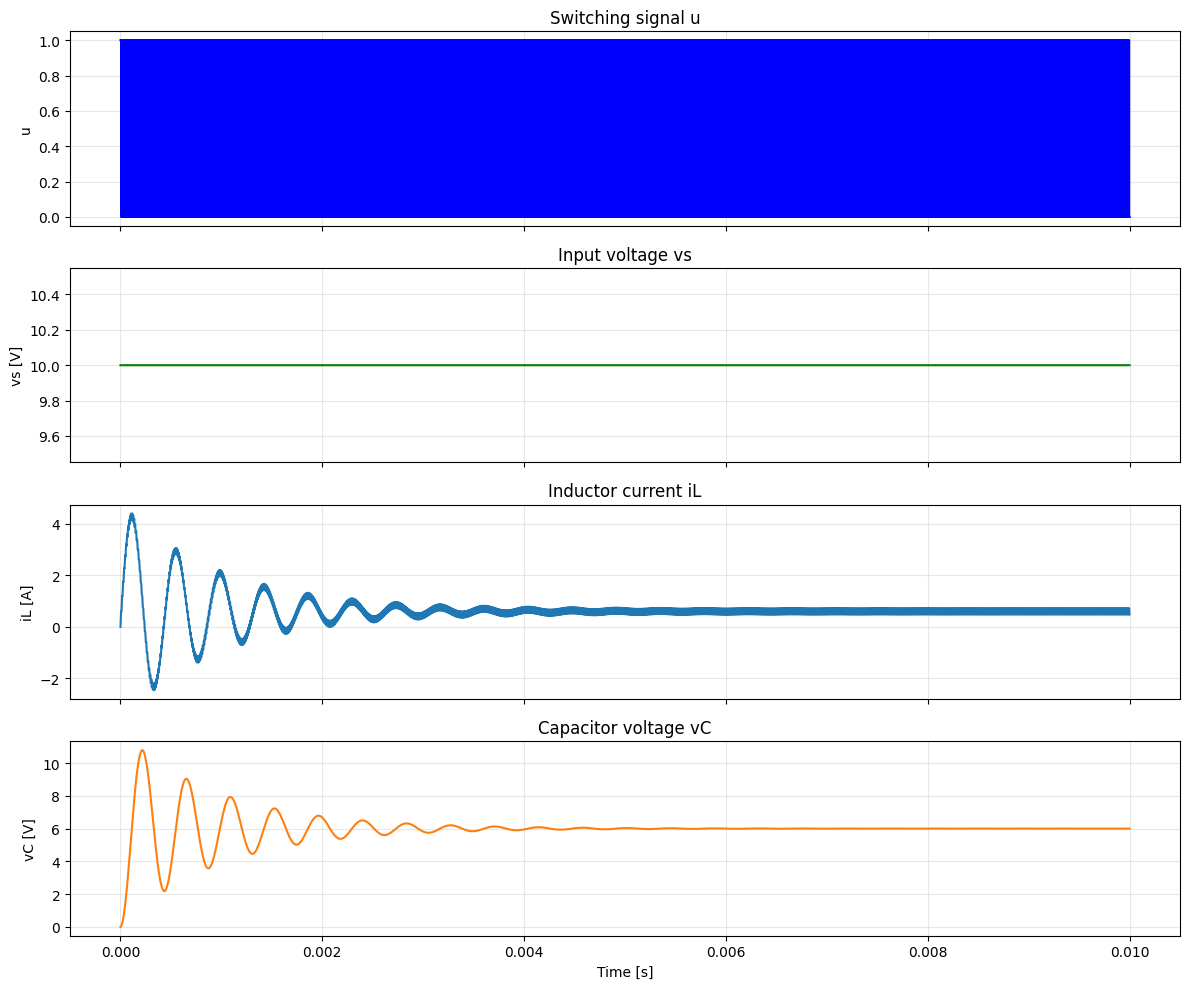

In [92]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t[:-1], u, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t[:-1], vs, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t, iL, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t, vC, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


# 前処理


In [93]:
tail_length: int = points_per_cycle * 10
train_ratio: float = 0.3
valid_ratio: float = 0.3
# test_ratio = 1 - train_ratio - valid_ratio


In [94]:
TimeStep = xs_sim.shape[0]  # 全ステップ数 N

tail_steps = tail_length
start_tail = TimeStep - tail_steps  # 尻尾の開始インデックス

# 尻尾区間の入力・dt・状態
xs_tail = xs_sim[start_tail:]  # [tail_steps, 1, 2]
dt_tail = input_dt_sim[start_tail:]  # [tail_steps, 1]
h_tail = h_pred_train[start_tail:]  # [tail_steps+1, 1, 2]


n_tail = xs_tail.shape[0]  # = tail_steps

n_train = int(n_tail * train_ratio)
n_valid = int(n_tail * valid_ratio)
n_test = n_tail - n_train - n_valid  # 端数をここに押し込む

# インデックス
train_start = 0
train_end = train_start + n_train  # [0, n_train)
valid_start = train_end
valid_end = valid_start + n_valid  # [n_train, n_train+n_valid)
test_start = valid_end  # [valid_end, n_tail)
test_end = n_tail


In [95]:
# train
xs_train = xs_tail[train_start:train_end]  # [n_train, 1, 2]
dt_train = dt_tail[train_start:train_end]  # [n_train, 1]
y_train = h_tail[train_start + 1 : train_end + 1]  # [n_train, 1, 2]
h0_train = h_tail[train_start]  # shape [1, 2]

# valid
xs_valid = xs_tail[valid_start:valid_end]
dt_valid = dt_tail[valid_start:valid_end]
y_valid = h_tail[valid_start + 1 : valid_end + 1]
h0_valid = h_tail[valid_start]

# test
xs_test = xs_tail[test_start:test_end]
dt_test = dt_tail[test_start:test_end]
y_test = h_tail[test_start + 1 : test_end + 1]
h0_test = h_tail[test_start]


In [96]:
print(f"{xs_train.shape=}")
print(f"{dt_train.shape=}")
print(f"{y_train.shape=}")
print(f"{h0_train.shape=}")

print(f"{xs_valid.shape=}")
print(f"{dt_valid.shape=}")
print(f"{y_valid.shape=}")
print(f"{h0_valid.shape=}")

print(f"{xs_test.shape=}")
print(f"{dt_test.shape=}")
print(f"{y_test.shape=}")
print(f"{h0_test.shape=}")

xs_train.shape=torch.Size([600, 1, 2])
dt_train.shape=torch.Size([600, 1])
y_train.shape=torch.Size([600, 1, 2])
h0_train.shape=torch.Size([1, 2])
xs_valid.shape=torch.Size([600, 1, 2])
dt_valid.shape=torch.Size([600, 1])
y_valid.shape=torch.Size([600, 1, 2])
h0_valid.shape=torch.Size([1, 2])
xs_test.shape=torch.Size([800, 1, 2])
dt_test.shape=torch.Size([800, 1])
y_test.shape=torch.Size([800, 1, 2])
h0_test.shape=torch.Size([1, 2])


# 学習


In [ ]:
lr_L = 1e-2
lr_C = 5e-2
lr_R = 2e-2

L0 = 200e-6
C0 = 100e-6
R0 = 8.0

epochs = 1000

model = BuckConverterRNNModel(L_init=L0, C_init=C0, R_init=R0)

optimizer = optim.Adam(
    [
        {"params": [model.cell.log_L], "lr": lr_L},
        {"params": [model.cell.log_C], "lr": lr_C},
        {"params": [model.cell.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

loss_history = {"train": [], "valid": []}
param_history = {"L": [], "C": [], "R": []}


for epoch in range(1, epochs + 1):
    model.train()

    # --- train 区間 ---
    out_train = model(h0_train, xs_train, dt_train)  # [n_train+1, 1, 2]
    y_pred_train = out_train[1:]  # h1..h_T を取り出す

    loss_train = loss_fn(y_pred_train, y_train)

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # --- valid 区間で評価 ---
    model.eval()
    with torch.no_grad():
        out_valid = model(h0_valid, xs_valid, dt_valid)
        y_pred_valid = out_valid[1:]
        loss_valid = loss_fn(y_pred_valid, y_valid)

    # 学習結果を記録
    loss_history["train"].append(loss_train.item())
    loss_history["valid"].append(loss_valid.item())

    param_history["L"].append(model.cell.log_L.exp().item())
    param_history["C"].append(model.cell.log_C.exp().item())
    param_history["R"].append(model.cell.log_R.exp().item())

    if epoch % 100 == 0:
        params = (
            model.cell.log_L.exp().item(),
            model.cell.log_C.exp().item(),
            model.cell.log_R.exp().item(),
        )
        print(
            f"Epoch {epoch:4d} | "
            f"train={loss_train.item():.4e} | valid={loss_valid.item():.4e} | "
            f"L={params[0]:.3e}, C={params[1]:.3e}, R={params[2]:.3f}"
        )

Epoch  100 | train=1.8683e-03 | valid=1.8640e-03 | L=1.811e-04, C=4.756e-04, R=8.543
Epoch  200 | train=1.4244e-03 | valid=1.4204e-03 | L=1.642e-04, C=5.852e-04, R=8.637
Epoch  300 | train=1.0188e-03 | valid=1.0152e-03 | L=1.494e-04, C=6.417e-04, R=8.689
Epoch  400 | train=6.7181e-04 | valid=6.6882e-04 | L=1.366e-04, C=6.737e-04, R=8.724
Epoch  500 | train=4.0050e-04 | valid=3.9829e-04 | L=1.260e-04, C=6.977e-04, R=8.756
Epoch  600 | train=2.1169e-04 | valid=2.1026e-04 | L=1.175e-04, C=7.235e-04, R=8.793
Epoch  700 | train=9.7857e-05 | valid=9.7063e-05 | L=1.111e-04, C=7.550e-04, R=8.839
Epoch  800 | train=3.9779e-05 | valid=3.9419e-05 | L=1.066e-04, C=7.918e-04, R=8.893
Epoch  900 | train=1.5050e-05 | valid=1.4912e-05 | L=1.037e-04, C=8.304e-04, R=8.952
Epoch 1000 | train=6.2529e-06 | valid=6.2102e-06 | L=1.019e-04, C=8.666e-04, R=9.013


# 検証


In [98]:
# ==========
#  最終的な test loss
# ==========
model.eval()
with torch.no_grad():
    preds_t = model(h0_test, xs_test, dt_test)
    test_loss = loss_fn(preds_t[1:], y_test)

print(f"Final test loss: {test_loss.item():.6e}")

print(
    "Estimated params:",
    "L =",
    param_history["L"][-1],
    "C =",
    param_history["C"][-1],
    "R =",
    param_history["R"][-1],
)


Final test loss: 6.446690e-06
Estimated params: L = 0.00010186869621975347 C = 0.0008666381472721696 R = 9.012580871582031


# 結果


## 設定


In [99]:
final_train_loss = loss_history["train"][-1]
final_valid_loss = loss_history["valid"][-1]
final_test_loss = test_loss.item()

final_L = param_history["L"][-1]
final_C = param_history["C"][-1]
final_R = param_history["R"][-1]

# 実験設定の表示
print("=" * 60)
print()
print("【回路パラメータ】")
print(f"  真の値: L = {L_true:.6e} [H], C = {C_true:.6e} [F], R = {R_true:.3f} [Ω]")
print(f"  初期値: L = {L0:.6e} [H], C = {C0:.6e} [F], R = {R0:.3f} [Ω]")
print(f"  推論値: L = {final_L:.6e} [H], C = {final_C:.6e} [F], R = {final_R:.3f} [Ω]")
print()
print("【入力条件】")
print(f"  Vin (入力電圧) = {Vin:.2f} [V], Vref (目標電圧) = {Vref:.2f} [V]")
print(f"  スイッチング周波数 f_sw = {f_sw:.0f} [Hz]")
print(f"  1周期あたりのプロット数 = {points_per_cycle}")
print()
print("【学習設定】")
print(f"  エポック数 = {epochs}")
print(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")
print()
print("【データ分割】")
print(f"  学習データ: {n_train} ステップ")
print(f"  検証データ: {n_valid} ステップ")
print(f"  テストデータ: {n_test} ステップ")
print()
print("【最終Loss】")
print(f"  学習データ: {final_train_loss:.6e}")
print(f"  検証データ: {final_valid_loss:.6e}")
print(f"  テストデータ: {final_test_loss:.6e}")
print()
print("【学習設定】")
print(f"  エポック数: {epochs}")
print(f"  学習率: L = {lr_L:.2e}, C = {lr_C:.2e}, R = {lr_R:.2e}")



【回路パラメータ】
  真の値: L = 1.000000e-04 [H], C = 4.800000e-05 [F], R = 10.000 [Ω]
  初期値: L = 2.000000e-04 [H], C = 1.000000e-04 [F], R = 8.000 [Ω]
  推論値: L = 1.018687e-04 [H], C = 8.666381e-04 [F], R = 9.013 [Ω]

【入力条件】
  Vin (入力電圧) = 10.00 [V], Vref (目標電圧) = 6.00 [V]
  スイッチング周波数 f_sw = 100000 [Hz]
  1周期あたりのプロット数 = 200

【学習設定】
  エポック数 = 1000
  学習率: L = 1.00e-03, C = 5.00e-02, R = 2.00e-03

【データ分割】
  学習データ: 600 ステップ
  検証データ: 600 ステップ
  テストデータ: 800 ステップ

【最終Loss】
  学習データ: 6.252864e-06
  検証データ: 6.210157e-06
  テストデータ: 6.446690e-06

【学習設定】
  エポック数: 1000
  学習率: L = 1.00e-03, C = 5.00e-02, R = 2.00e-03


## 学習に使ったデータのグラフ


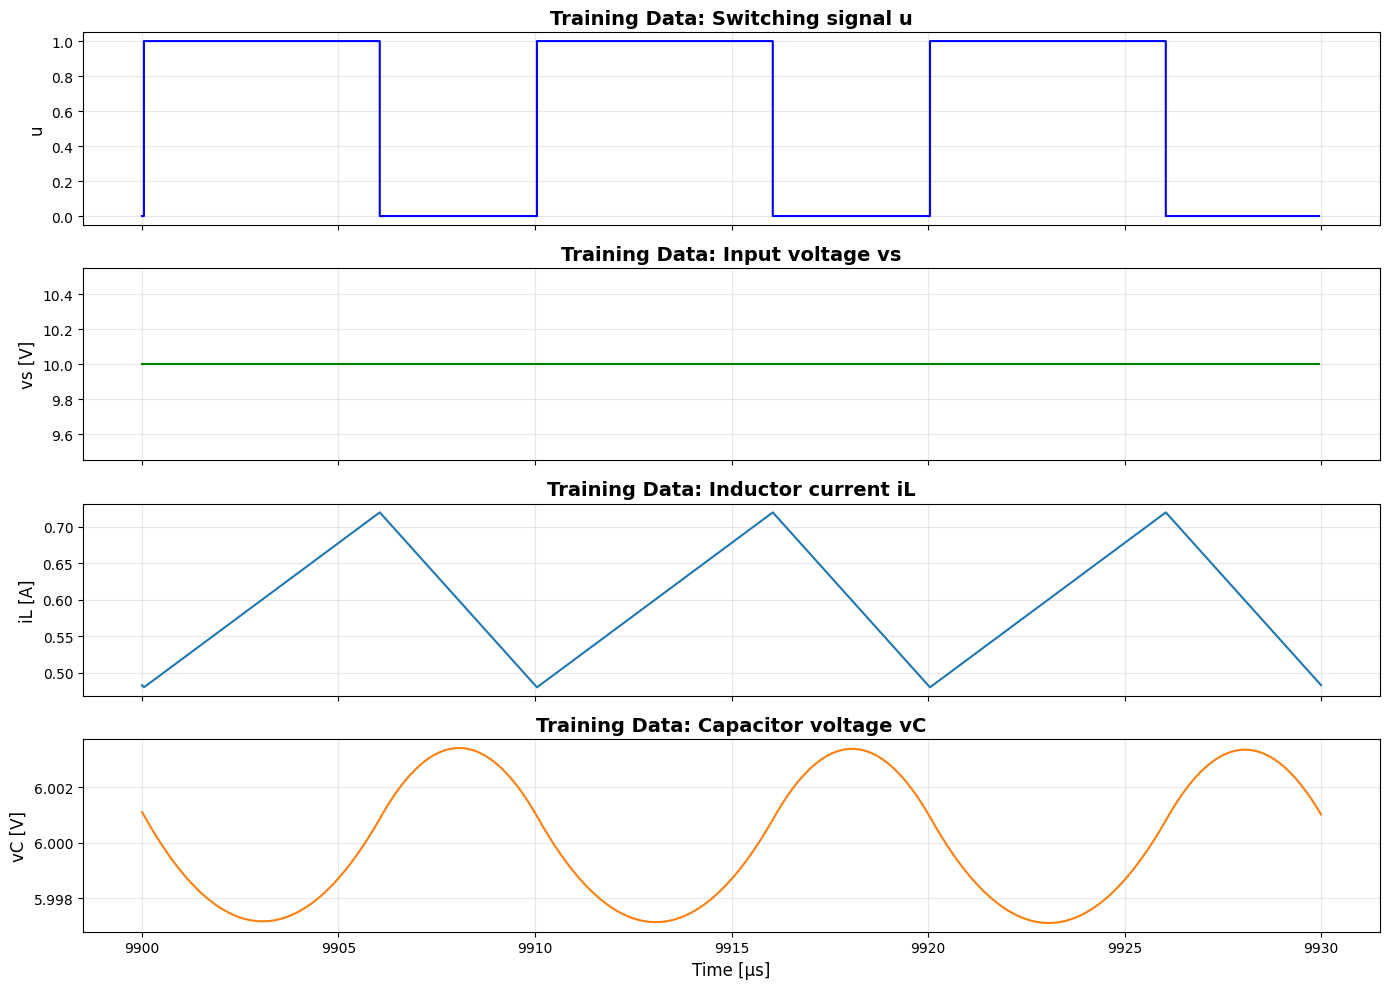

In [100]:
# 学習に使ったデータの抽出
# 学習データの時間範囲を計算
train_start_idx = start_tail + train_start
train_end_idx = start_tail + train_end

# 学習データに対応する時間と信号を抽出
t_train = t[train_start_idx : train_end_idx + 1]  # +1はh0を含むため
u_train = u[train_start_idx:train_end_idx]
vs_train = vs[train_start_idx:train_end_idx]
iL_train = iL[train_start_idx : train_end_idx + 1]
vC_train = vC[train_start_idx : train_end_idx + 1]

# グラフ表示
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t_train[:-1] * 1e6, u_train, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u", fontsize=12)
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Training Data: Switching signal u", fontsize=14, fontweight="bold")

# 2: vs (input voltage)
axs[1].plot(t_train[:-1] * 1e6, vs_train, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]", fontsize=12)
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Training Data: Input voltage vs", fontsize=14, fontweight="bold")

# 3: iL (inductor current)
axs[2].plot(t_train * 1e6, iL_train, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]", fontsize=12)
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Training Data: Inductor current iL", fontsize=14, fontweight="bold")

# 4: vC (capacitor voltage)
axs[3].plot(t_train * 1e6, vC_train, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]", fontsize=12)
axs[3].set_xlabel("Time [μs]", fontsize=12)
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Training Data: Capacitor voltage vC", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()


## Loss の遷移


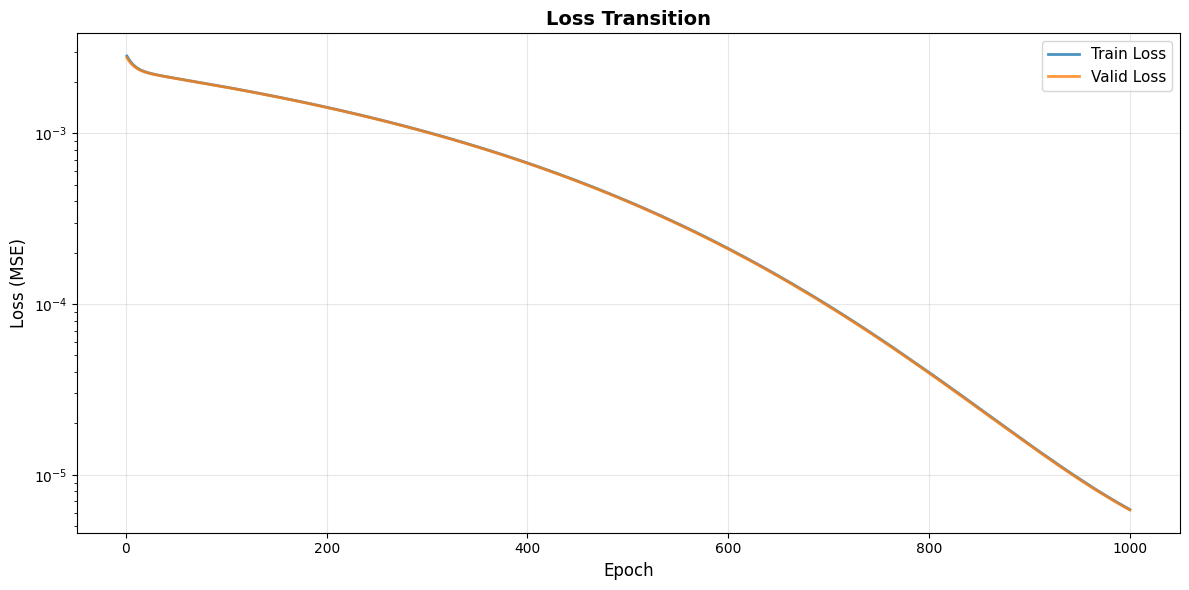

In [101]:
# Lossの遷移をグラフ表示
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

epochs_list = range(1, epochs + 1)
ax.plot(epochs_list, loss_history["train"], label="Train Loss", linewidth=2, alpha=0.8)
ax.plot(epochs_list, loss_history["valid"], label="Valid Loss", linewidth=2, alpha=0.8)

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Loss Transition", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()


## 回路パラメータの学習による変化


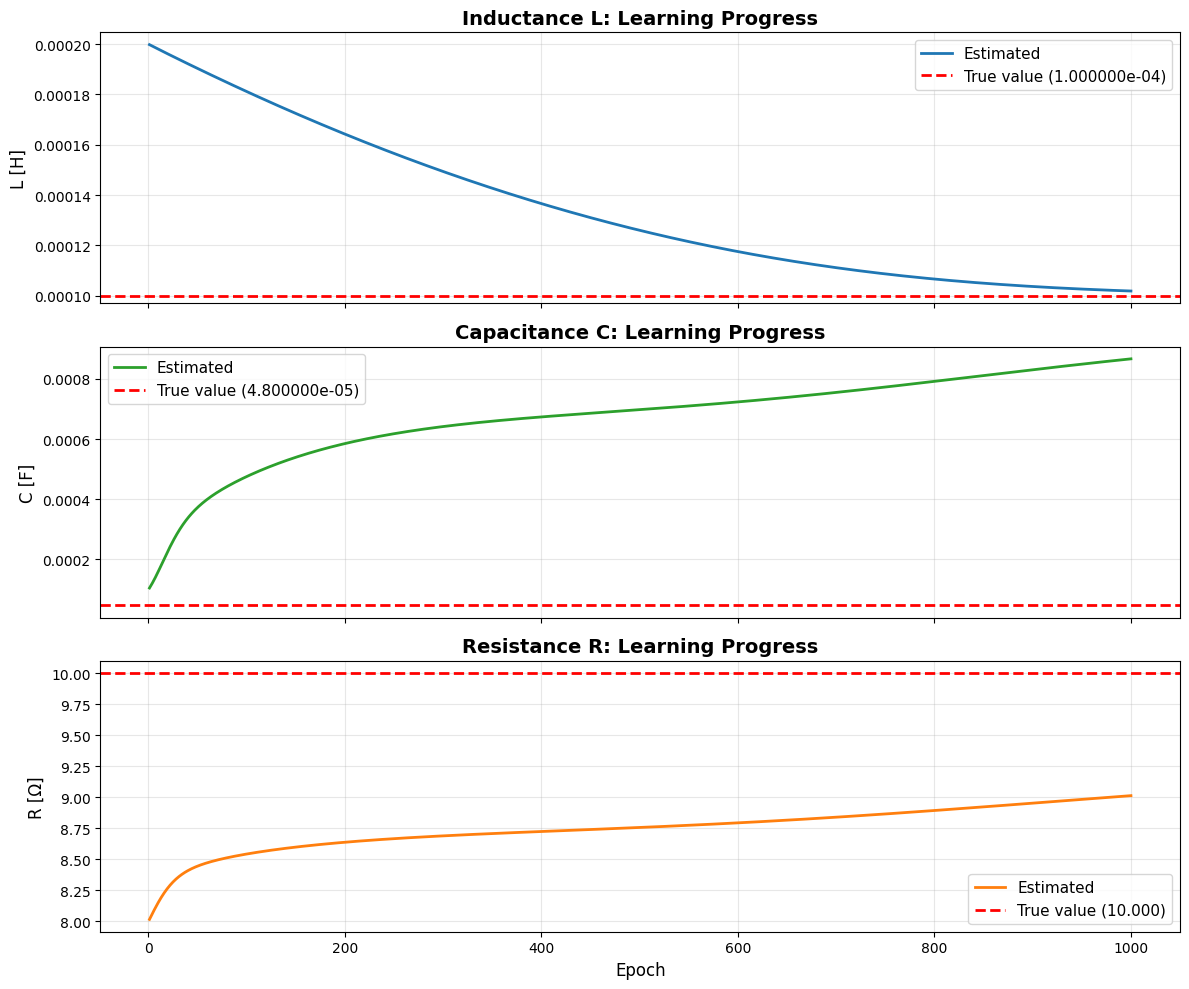

In [102]:
# 回路パラメータの学習による変化をグラフ表示
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

epochs_list = range(1, epochs + 1)

# Lの変化
axs[0].plot(
    epochs_list, param_history["L"], label="Estimated", linewidth=2, color="tab:blue"
)
axs[0].axhline(
    y=L_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({L_true:.6e})",
)
axs[0].set_ylabel("L [H]", fontsize=12)
axs[0].set_title("Inductance L: Learning Progress", fontsize=14, fontweight="bold")
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# Cの変化
axs[1].plot(
    epochs_list, param_history["C"], label="Estimated", linewidth=2, color="tab:green"
)
axs[1].axhline(
    y=C_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({C_true:.6e})",
)
axs[1].set_ylabel("C [F]", fontsize=12)
axs[1].set_title("Capacitance C: Learning Progress", fontsize=14, fontweight="bold")
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

# Rの変化
axs[2].plot(
    epochs_list, param_history["R"], label="Estimated", linewidth=2, color="tab:orange"
)
axs[2].axhline(
    y=R_true,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"True value ({R_true:.3f})",
)
axs[2].set_ylabel("R [Ω]", fontsize=12)
axs[2].set_xlabel("Epoch", fontsize=12)
axs[2].set_title("Resistance R: Learning Progress", fontsize=14, fontweight="bold")
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=11)

plt.tight_layout()
plt.show()


## テストデータでの予測結果と真の値の比較


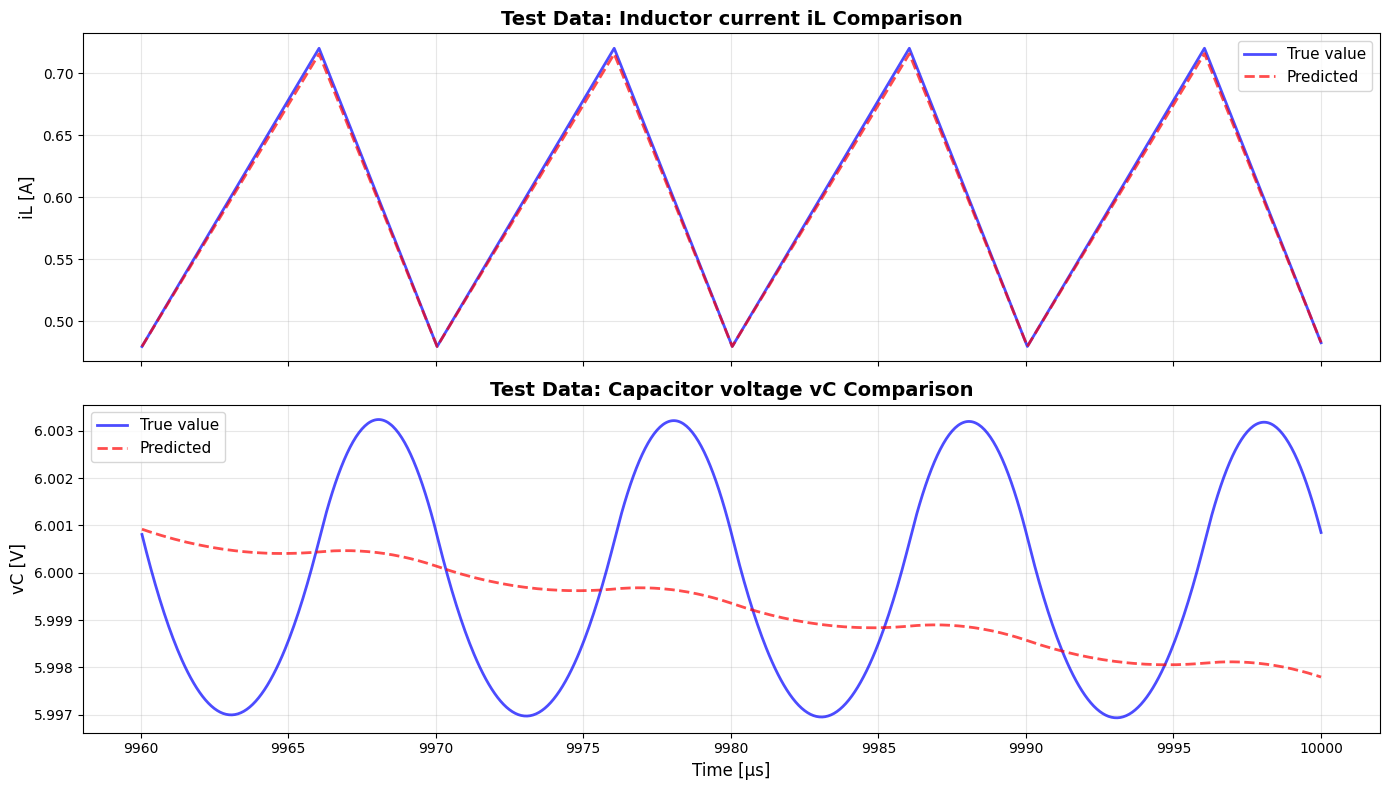

In [103]:
# テストデータでの予測結果を取得
model.eval()
with torch.no_grad():
    preds_test = model(h0_test, xs_test, dt_test)

# 予測結果をnumpy配列に変換
preds_test_np = preds_test[1:, 0, :].cpu().detach().numpy()  # [n_test, 2]
y_test_np = y_test[:, 0, :].cpu().detach().numpy()  # [n_test, 2]

# テストデータの時間範囲を計算
test_start_idx = start_tail + test_start
test_end_idx = start_tail + test_end
t_test = t[test_start_idx : test_end_idx + 1]  # +1はh0を含むため

# 真の値（iL, vC）
iL_test_true = y_test_np[:, 0]
vC_test_true = y_test_np[:, 1]

# 予測値（iL, vC）
iL_test_pred = preds_test_np[:, 0]
vC_test_pred = preds_test_np[:, 1]

# グラフ表示
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# iLの比較
axs[0].plot(
    t_test[1:] * 1e6,
    iL_test_true,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[0].plot(
    t_test[1:] * 1e6,
    iL_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[0].set_ylabel("iL [A]", fontsize=12)
axs[0].set_title(
    "Test Data: Inductor current iL Comparison", fontsize=14, fontweight="bold"
)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=11)

# vCの比較
axs[1].plot(
    t_test[1:] * 1e6,
    vC_test_true,
    label="True value",
    linewidth=2,
    alpha=0.7,
    color="blue",
)
axs[1].plot(
    t_test[1:] * 1e6,
    vC_test_pred,
    label="Predicted",
    linewidth=2,
    alpha=0.7,
    color="red",
    linestyle="--",
)
axs[1].set_ylabel("vC [V]", fontsize=12)
axs[1].set_xlabel("Time [μs]", fontsize=12)
axs[1].set_title(
    "Test Data: Capacitor voltage vC Comparison", fontsize=14, fontweight="bold"
)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()
